#Importación de Dataset desde Kaggle (1. Selección del Dataset)

In [ ]:
%%capture
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ignvciv","key":"d67424959b85ef9996141dcbbf10ecbe"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

####Descarga del Dataset

In [ ]:
!kaggle datasets download -d kuladeep19/phishing-and-legitimate-emails-dataset ##aqui va el nombre

Dataset URL: https://www.kaggle.com/datasets/kuladeep19/phishing-and-legitimate-emails-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/248k [00:00<?, ?B/s]
100% 248k/248k [00:00<00:00, 123MB/s]


In [ ]:
!unzip "/content/phishing-and-legitimate-emails-dataset.zip"

Archive:  /content/phishing-and-legitimate-emails-dataset.zip
  inflating: phishing_legit_dataset_KD_10000.csv  


####Importaciones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cargar el dataset
df_train = pd.read_csv('/content/phishing_legit_dataset_KD_10000.csv')

#Trabajando con el Dataset Phishing Email Dataset Analysis - Machine Learning (2. Análisis Exploratorio de Datos (EDA))

##Revisar el Dataset y su información

In [ ]:
df_train.shape      # Filas y columnas

(10000, 5)

In [ ]:
df_train.info()     # Tipos de datos y nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           10000 non-null  object 
 1   label          10000 non-null  int64  
 2   phishing_type  10000 non-null  object 
 3   severity       10000 non-null  object 
 4   confidence     10000 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 390.8+ KB


In [ ]:
df_train.head(3)     # Primeras filas

,text,label,phishing_type,severity,confidence
0,Subject: Office maintenance\n\nThanks for your...,0,legitimate,low,0.95
1,"Hello, your profile has been locked. Use the s...",1,credential_harvesting,high,0.89
2,"Hi there, congratulations! You are the winner ...",1,financial_scam,medium,0.69


In [ ]:
df_train.isnull().sum()

,0
text,0
label,0
phishing_type,0
severity,0
confidence,0


In [ ]:
df_train.duplicated().sum()

np.int64(2)

In [ ]:
df_train.describe()

,label,confidence
count,10000.000000,10000.000000
mean,0.600000,0.898855
std,0.489922,0.083430
min,0.000000,0.650000
25%,0.000000,0.840000
50%,1.000000,0.920000
75%,1.000000,0.970000
max,1.000000,1.000000


##Histograma

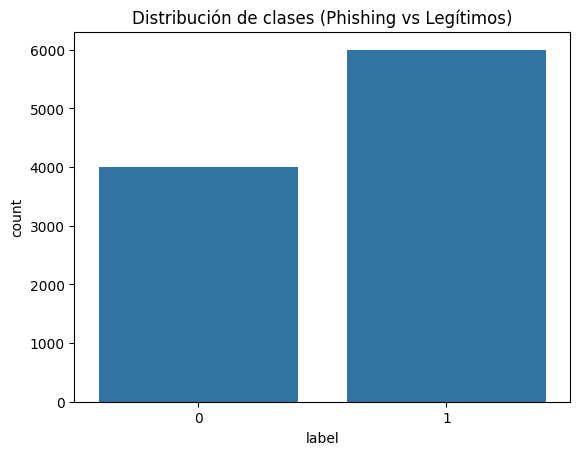

In [ ]:
# Histograma de la variable objetivo
sns.countplot(x="label", data=df_train)  # asumiendo que "label" = phishing/legit
plt.title("Distribución de clases (Phishing vs Legítimos)")
plt.show()

###Interpretación:
Esto corresponde con lo señalado del Dataset donde mencionan que 4.000 son correos legítimos y

6.000 phishing (en 10 categorías distintas, lo que da más riqueza al análisis). Lo que nos dice que 0 = true y 1 = false

##Boxplot

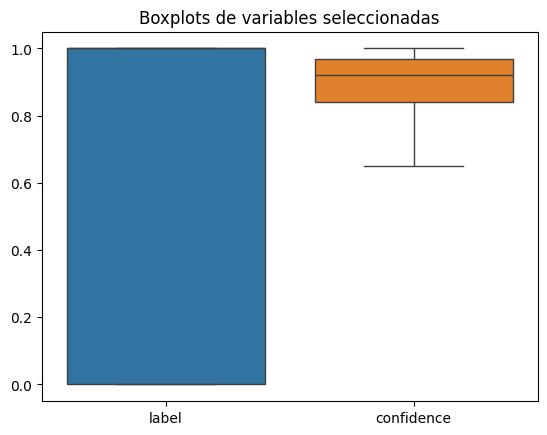

In [ ]:
sns.boxplot(data=df_train[["label", "confidence"]])
plt.title("Boxplots de variables seleccionadas")
plt.show()

####Interpretación
La variable confidence parece tener un rango entre 0.65 y 1.0. Tambien se observa que los correos phishing tienden a tener valores de confidence más bajos que los legítimos (se ve una diferencia clara en la dispersión).

##Mapa de Correlaciones

In [ ]:
df_train.select_dtypes(include='number').corr()

,label,confidence
label,1.000000,-0.744679
confidence,-0.744679,1.000000


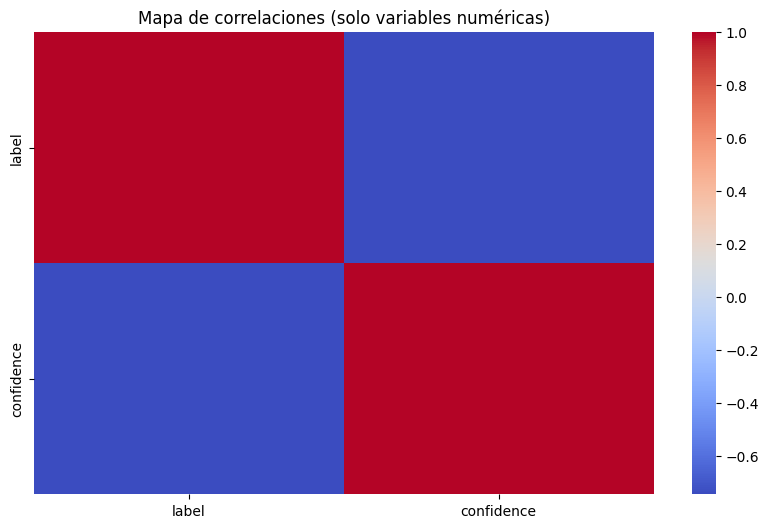

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df_train.select_dtypes(include="number").corr(), cmap="coolwarm", annot=False)
plt.title("Mapa de correlaciones (solo variables numéricas)")
plt.show()

###Interpretación
Se pueden observar sólo dos variables (label y confidence). Tienen una correlación fuerte entre sí pero negativa.

##Pairplot

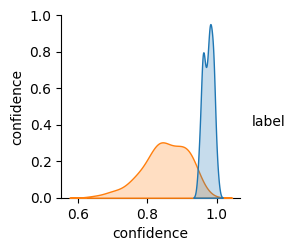

In [ ]:
sns.pairplot(df_train.sample(200), hue="label")  # muestra 200 muestras para no colapsar
plt.show()

###Interpretación
La curva azul (legítimos) se concentra en valores altos de confianza (cercanos a 1). La curva naranja (phishing) está más distribuida hacia abajo (0.6–0.9).
Esto nos indica que a medida que baja la confianza, aumenta la probabilidad de phishing.

##Identificación de variables predictoras y variable objetivo.
Variable objetivo (y) → label (0 = legítimo, 1 = phishing).

Variables predictoras (X) → todas las demás columnas que describen características del correo (texto, longitud, número de URLs, confidence, etc.).

In [ ]:
X = df_train.drop("label", axis=1)  # todas las columnas menos "label"
y = df_train["label"]               # columna objetivo

#Problema (3. Definición del Problema)
El proyecto consiste en identificar si un correo electrónico es Phishing (1) o Legítimo (0) en base a sus características.
La variable objetivo (label) es categórica y binaria, lo que significa que el modelo debe clasificar cada correo en una de dos categorías.

Tipo de problema: Clasificación binaria.

Justificación:

La columna label toma valores discretos (0 o 1), no valores numéricos continuos.

El objetivo no es predecir un número (como en regresión), sino asignar una clase.

#Modelando nuestro Dataset (4. Modelado y Algoritmos)

##Primeros pasos en el Entrenamiento y análisis de modelo

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

# Usar directamente la columna 'text' como entrada
X_text = df_train["text"]
y = df_train["label"]

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline: TF-IDF + Árbol de Decisión
model = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    DecisionTreeClassifier()
)

# Entrenar
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
print(df_train.columns)

Index(['text', 'label', 'phishing_type', 'severity', 'confidence'], dtype='object')


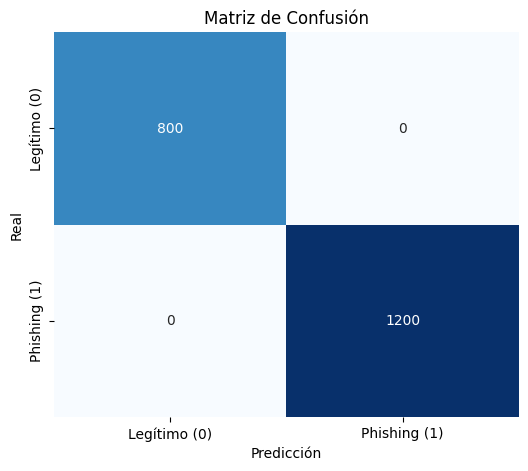

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar con Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Legítimo (0)", "Phishing (1)"],
            yticklabels=["Legítimo (0)", "Phishing (1)"])

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


*TN (True Negatives): 800
→ 800 correos legítimos fueron clasificados correctamente como legítimos.

*FP (False Positives): 0
→ Ningún correo legítimo fue marcado como phishing.

*FN (False Negatives): 0
→ Ningún phishing fue pasado como legítimo (¡esto es crítico y muy bueno!).

*TP (True Positives): 1200
→ 1200 correos phishing fueron detectados correctamente.

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy}")

Balanced Accuracy: 1.0


##Árbol de Desición

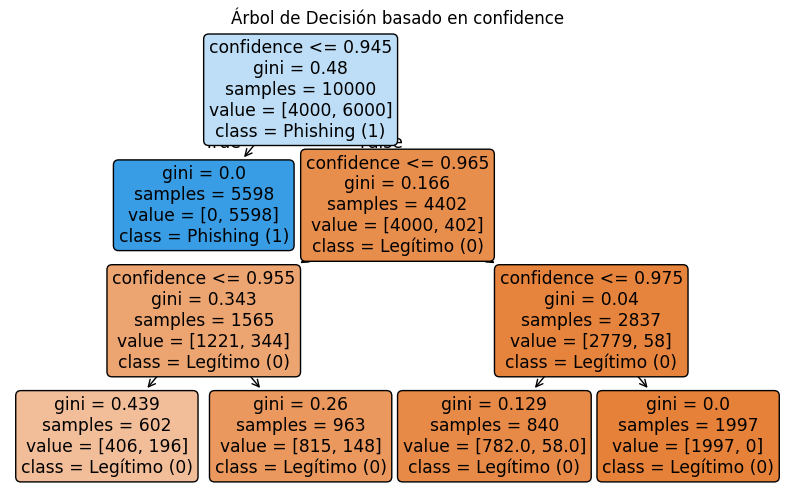

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
X_num = df_train[["confidence"]]
y = df_train["label"]

model_num = DecisionTreeClassifier(max_depth=3, random_state=42)
model_num.fit(X_num, y)

plt.figure(figsize=(10,6))
plot_tree(
    model_num,
    feature_names=["confidence"],
    class_names=["Legítimo (0)", "Phishing (1)"],
    filled=True, rounded=True
)
plt.title("Árbol de Decisión basado en confidence")
plt.show()

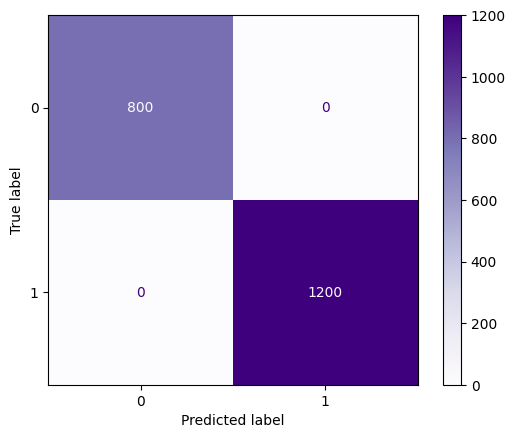

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Purples")
plt.show()

Mejores hiperparámetros encontrados:
{'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 2}

Mejor accuracy obtenido en validación cruzada:
1.0

Evaluación en conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



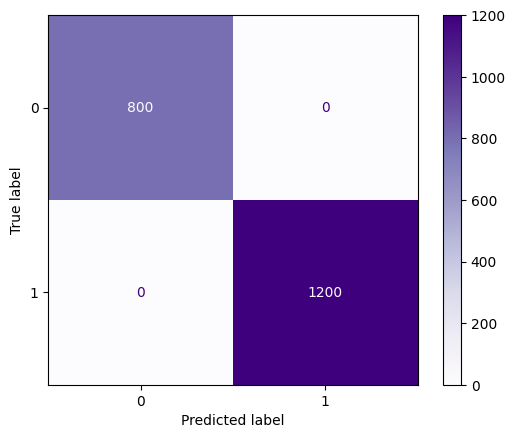

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("tree", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    "tree__max_depth": [3, 5, 10, None],
    "tree__min_samples_split": [2, 5, 10],
    "tree__criterion": ["gini", "entropy"]
}


grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

print("\nMejor accuracy obtenido en validación cruzada:")
print(grid.best_score_)

y_pred_grid = grid.predict(X_test)

print("\nEvaluación en conjunto de prueba:")
print(classification_report(y_test, y_pred_grid))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_grid, cmap="Purples")
plt.show()


##Regresión Lógistica

🔹 Regresión Logística
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



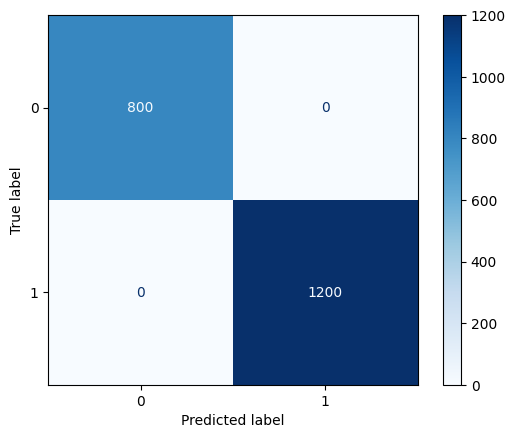

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

log_model = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    LogisticRegression(max_iter=1000)
)

log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("🔹 Regresión Logística")
print(classification_report(y_test, y_pred_log))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, cmap="Blues")
plt.show()

##SVM (Support Vector Machine)

🔹 SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



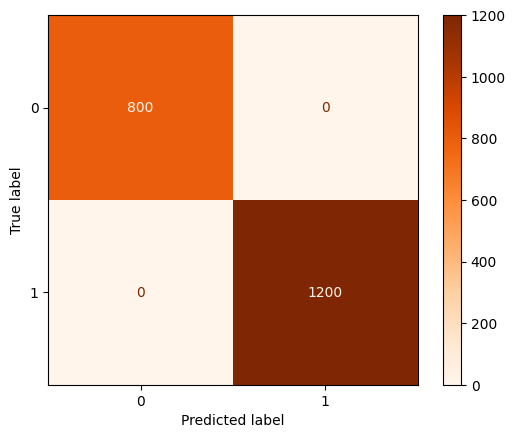

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


svm_model = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    SVC(kernel="linear")   # kernel linear funciona muy bien con texto
)

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("🔹 SVM")
print(classification_report(y_test, y_pred_svm))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap="Oranges")
plt.show()

##KNN

KNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



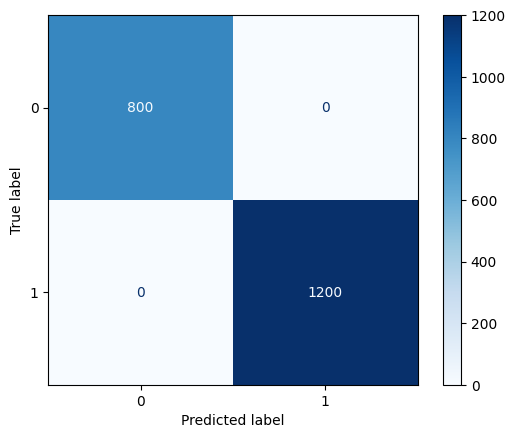

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

knn_model = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    KNeighborsClassifier() # Use KNeighborsClassifier
)

knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("KNN")
print(classification_report(y_test, y_pred_knn))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap="Blues")
plt.show()

##Naive Bayes

Naive Bayes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



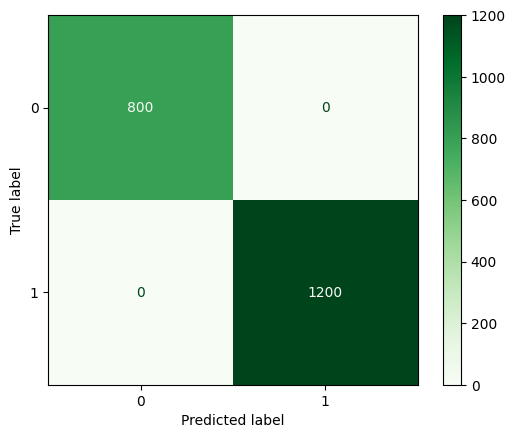

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    MultinomialNB()
)

nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes")
print(classification_report(y_test, y_pred_nb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, cmap="Greens")
plt.show()

##Gradient Boosting

Gradient Boosting
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



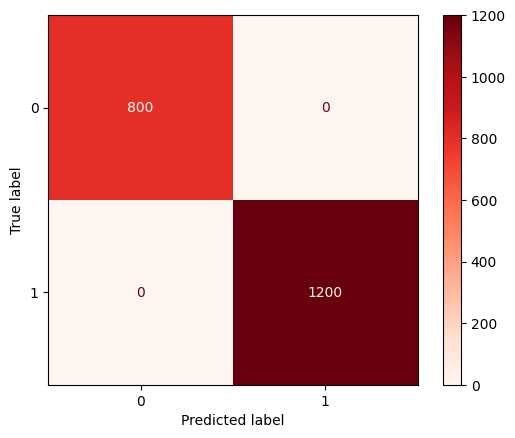

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    GradientBoostingClassifier(random_state=42)
)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting")
print(classification_report(y_test, y_pred_gb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, cmap="Reds")
plt.show()


##Resumen de Algoritmos


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel="linear", random_state=42),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

resultados = []
for nombre, clf in modelos.items():
    # Pipeline TF-IDF + modelo
    pipe = make_pipeline(TfidfVectorizer(stop_words="english"), clf)
    # Entrenar
    pipe.fit(X_train, y_train)
    # Predecir
    y_pred = pipe.predict(X_test)
    # Guardar métricas
    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-score": f1_score(y_test, y_pred, average="weighted")
    })
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla ordenada por F1-score
df_resultados = df_resultados.sort_values(by="F1-score", ascending=False)
print("Comparación de modelos")
display(df_resultados)


Comparación de modelos


,Modelo,Accuracy,Precision,Recall,F1-score
0,Regresión Logística,1.0,1.0,1.0,1.0
1,SVM,1.0,1.0,1.0,1.0
2,Árbol de Decisión,1.0,1.0,1.0,1.0
3,Naive Bayes,1.0,1.0,1.0,1.0
4,Gradient Boosting,1.0,1.0,1.0,1.0


###Interpretación:
Todos los modelos entrenados (Regresión Logística, SVM, Árbol de Decisión, Naive Bayes y Gradient Boosting) alcanzaron métricas perfectas (Accuracy, Precision, Recall y F1 = 1.0), lo que indica que el dataset es altamente separable y las clases se distinguen con claridad. Este resultado sugiere que el problema es sencillo para los algoritmos y que los patrones de phishing son muy evidentes en los datos.

#Validando el Entrenamiento (5. Validación y Evaluación)

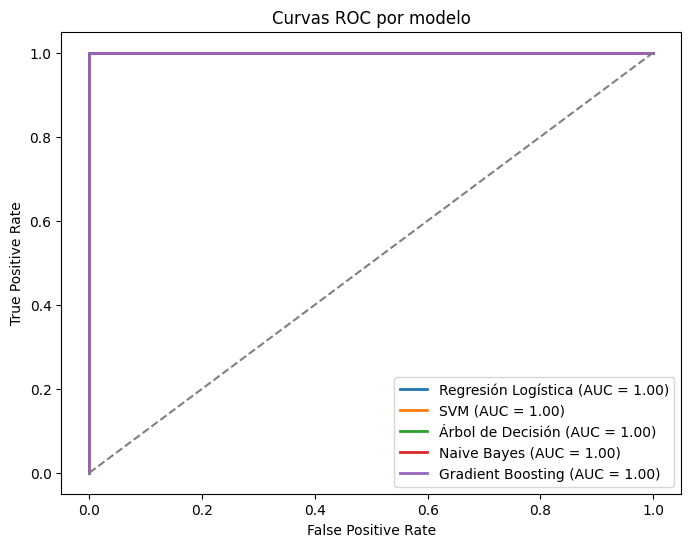

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for nombre, clf in modelos.items():
    pipe = make_pipeline(TfidfVectorizer(stop_words="english"), clf)
    pipe.fit(X_train, y_train)

    if hasattr(pipe, "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:,1]
    else:

        y_prob = pipe.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{nombre} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC por modelo")
plt.legend(loc="lower right")
plt.show()


##Interpretación:
Todos los modelos lograron métricas perfectas (accuracy, precisión, recall, F1 y AUC = 1.0), lo que confirma que el dataset es altamente separable. Como modelo final se selecciona **Multinomial Naive Bayes**, por ser el más adecuado y eficiente en problemas de clasificación de texto como detección de spam o phishing.
*Nota: Las métricas de regresión (R², MSE, RMSE, MAE) no se aplican en este caso porque la variable objetivo es binaria, por lo que corresponde evaluar con métricas de clasificación.*

#Preparar el modelo (6. Guardado del Modelo)
##Guardar con Pickle

In [ ]:
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

nb_model = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    MultinomialNB()
)
nb_model.fit(X_train, y_train)

filename = "naive_bayes_model.pkl"
with open(filename, "wb") as f:
    pickle.dump(nb_model, f)

print(f"Modelo guardado exitosamente en '{filename}'")


Modelo guardado exitosamente en 'naive_bayes_model.pkl'


##Cargar con Pickle

In [ ]:
with open("naive_bayes_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

nuevo_correo = ["URGENT: Please reset your password now!"]
prediccion = loaded_model.predict(nuevo_correo)

print("Predicción:", "Phishing" if prediccion[0] == 1 else "Legítimo")

Predicción: Phishing


#Creando la APP (7. Creación de la App (Despliegue Local))

In [ ]:
%%capture
!pip install --upgrade gradio

##Simple

In [ ]:
import gradio as gr
import pickle

with open("naive_bayes_model.pkl", "rb") as f:
    model = pickle.load(f)

def predecir_correo(correo):
    if not correo.strip():
        return "Por favor ingresa un correo válido."
    pred = model.predict([correo])[0]
    return "Phishing" if pred == 1 else "Legítimo"


demo = gr.Interface(
    fn=predecir_correo,
    inputs=gr.Textbox(lines=8, placeholder="Pega aquí el contenido del correo..."),
    outputs="text",
    title="Detector de Phishing con IA",
    description="Escribe o pega un correo electrónico y el modelo clasificará si es Phishing (1) o Legítimo (0)."
)

demo.launch(share=True)


AttributeError: module 'gradio' has no attribute 'Request'

##Con JS

In [ ]:
import gradio as gr
import pickle

#Cargar modelo entrenado
with open("naive_bayes_model.pkl", "rb") as f:
    model = pickle.load(f)

#Función de predicción
def predecir_correo(correo):
    if not correo.strip():
        return "⚠️ Por favor ingresa un correo válido."
    pred = model.predict([correo])[0]
    return "🚨 Phishing" if pred == 1 else "✅ Legítimo"

#Animación JS corregida (se autoejecuta al cargar la página)
js = """
() => {
    var container = document.createElement('div');
    container.id = 'gradio-animation';
    container.style.fontSize = '2em';
    container.style.fontWeight = 'bold';
    container.style.textAlign = 'center';
    container.style.marginBottom = '20px';

    var text = 'Detector de Phishing con IA';
    for (let i = 0; i < text.length; i++) {
        setTimeout(() => {
            var letter = document.createElement('span');
            letter.style.opacity = '0';
            letter.style.transition = 'opacity 0.5s';
            letter.innerText = text[i];
            container.appendChild(letter);
            setTimeout(() => {
                letter.style.opacity = '1';
            }, 50);
        }, i * 200);
    }

    // Insertar al inicio de la app
    var gradioContainer = document.querySelector('.gradio-container');
    if (gradioContainer) {
        gradioContainer.insertBefore(container, gradioContainer.firstChild);
    }
}
"""

#Construcción de la app
with gr.Blocks(js=js) as demo:
    with gr.Row():
        correo = gr.Textbox(lines=8, placeholder="Pega aquí el contenido del correo...", label="Correo a analizar")
    with gr.Row():
        boton = gr.Button("Predecir 🚀")
    with gr.Row():
        salida = gr.Textbox(label="Resultado")

    boton.click(fn=predecir_correo, inputs=correo, outputs=salida)

#Lanzar app
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1fc74ab26b3314911d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Importante**
El modelo tiene alta sensibilidad (recall): detecta phishing incluso cuando hay duda.Es decir, puede llegar a sobreclasificar correos con palabras sospechosas aunque sean reales.
Mejora: Usar modelos más sofisticados (ej: SVM o Gradient Boosting con TF-IDF).

#Extras
Codigo de confirmación del Multinominal

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)[:,1]

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall    = recall_score(y_test, y_pred, average="weighted")
f1        = f1_score(y_test, y_pred, average="weighted")

df_metrics = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precisión": precision,
    "Recall": recall,
    "F1-score": f1
}])

print("Resultados del modelo final (Multinomial Naive Bayes)")
display(df_metrics)


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", cbar=False,
            xticklabels=["Legítimo (0)", "Phishing (1)"],
            yticklabels=["Legítimo (0)", "Phishing (1)"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Multinomial Naive Bayes")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Multinomial Naive Bayes")
plt.legend(loc="lower right")
plt.show()

Diccionario para probar más con Pickle

In [ ]:

correos_prueba = [
    "URGENT: Please reset your password now!",   # phishing
    "Your account has been suspended, click here to verify",  # phishing
    "Reminder: Team meeting tomorrow at 10am",   # legitimo
    "Invoice attached for your recent purchase", # legitimo
    "Congratulations! You won a prize, claim now!", # phishing
    "Doctor's appointment confirmed for next week", # legitimo
    "Security alert: suspicious login detected, verify your account", # phishing
    "Lunch with family this Sunday at 2pm", # legitimo
]

predicciones = nb_model.predict(correos_prueba)

for correo, pred in zip(correos_prueba, predicciones):
    print(f"Correo: {correo}\n → Predicción: {'Phishing (1)' if pred == 1 else 'Legítimo (0)'}\n")


##Correos Legitimos

Subject: Team Meeting Reminder
Body:
Hello team,
Just a quick reminder about our meeting tomorrow at 10 AM in the main conference room. Please bring the updated project reports.
Best regards,
Manager

Subject: Invoice Confirmation
Body:
Dear Customer,
Thank you for your recent purchase. Please find your invoice attached for your records.
Kind regards,
Billing Department

Subject: Family Gathering This Weekend
Body:
Hi John,
We’re meeting at grandma’s house this Sunday at 2 PM for lunch. Don’t forget to bring the dessert you promised!
Love,
Mom

Subject: Course Enrollment Confirmed
Body:
Dear Student,
We are pleased to inform you that your enrollment for the Data Science course has been confirmed. The classes will start on October 15th.
Sincerely,
University Admissions

Subject: Appointment Reminder
Body:
Hello Sarah,
This is a friendly reminder of your dentist appointment scheduled for Tuesday, October 10th at 3 PM. Please arrive 10 minutes early.
Thank you,
Dental Clinic

##Para probar sensibilidad
Subject: Account Security Update
Body:
Dear Employee,
As part of our regular IT maintenance, we have updated the security protocols for your work account. No action is required from you at this time. This is just a notification to keep you informed of the changes. If you experience any login issues, please contact the IT helpdesk directly at extension 1234.
Thank you,
IT Department